# Step 3: Model construction

In [1]:
# Importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,\
classification_report, confusion_matrix, ConfusionMatrixDisplay


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier, plot_importance
import pickle

In [2]:
df = pd.read_csv('df_model.csv')

In [3]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Data Preparation

In [4]:
df_enc = df.copy()
df_enc['salary'] = df_enc['salary'].astype('category').cat.set_categories(['low', 'medium', 'high']).cat.codes
df_enc['salary'].unique()

array([0, 1, 2], dtype=int8)

In [5]:
df_enc = pd.get_dummies(df_enc, drop_first=False)

pd.set_option('display.max_columns', None)

df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [6]:
# determinig number of rows containing outliers
q1 = df['tenure'].quantile(0.25)
q3 = df['tenure'].quantile(0.75)
iqr = q3-q1
lower_limit = q1 - (1.5*iqr)
upper_limit = q3 + (1.5*iqr)

print('Lower limit:', lower_limit)
print('Upper limit:', upper_limit)

outliers = df[(df['tenure'] < lower_limit) | (df['tenure'] > upper_limit)]

print('Number of rows containing outliers:', len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows containing outliers: 824


## 1. Logistic Regression Model
- Logistic regression model is sensitive to outliers. Hence, outliers identified earlier are removed from the dataset.

In [7]:
# Removing outlier
df_lr = df_enc[(df_enc['tenure'] >= lower_limit) & (df_enc['tenure'] <= upper_limit)].reset_index(drop=True)
df_lr.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
3,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.41,0.50,2,153,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [8]:
# Isolating target feature
y = df_lr['left']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [9]:
# Showing class balance of target feature
y.value_counts(normalize=True)

0    0.831468
1    0.168532
Name: left, dtype: float64

There is an approximately 83%-17% split. So the data is not perfectly balanced, but it is not too imbalanced too.

In [10]:
# Model features
X = df_lr.drop('left', axis=1)
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.11,0.88,7,272,4,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.72,0.87,5,223,5,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0.37,0.52,2,159,3,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.41,0.50,2,153,3,0,0,0,0,0,0,0,0,0,0,1,0,0


In [11]:
# Splitting model feature into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)

In [12]:
log_clf = LogisticRegression(random_state=0, max_iter=500)

In [13]:
# Training the logistic model with training data
log_clf.fit(X_train, y_train)

LogisticRegression(max_iter=500, random_state=0)

In [14]:
# Predicting on test set
log_pred = log_clf.predict(X_test)

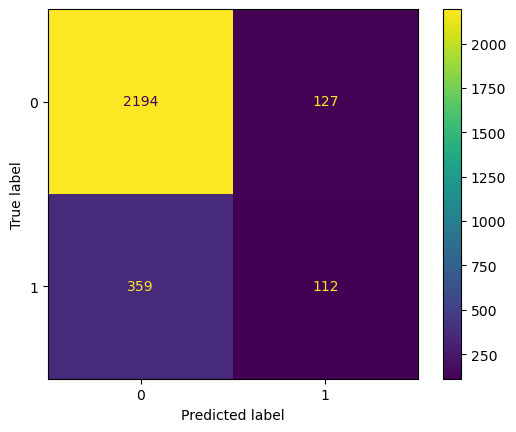

In [15]:
# Plotting confusion matrix to show model result
cm = confusion_matrix(y_test, log_pred, labels=log_clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log_clf.classes_)

disp.plot(values_format = '')

The upper-left quadrant displays the number of true negatives.  
The upper-right quadrant displays the number of false positives.  
The bottom-left quadrant displays the number of false negatives.  
The bottom-right quadrant displays the number of true positives.  

True negatives: The number of people who did not leave that the model accurately predicted did not leave.

False positives: The number of people who did not leave the model inaccurately predicted as leaving.

False negatives: The number of people who left that the model inaccurately predicted did not leave

True positives: The number of people who left the model accurately predicted as leaving

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

In [16]:
# Printing classification report
label = ['Predicted to stay', 'Predicted to leave']
print(classification_report(y_test, log_pred, target_names=label))

                    precision    recall  f1-score   support

 Predicted to stay       0.86      0.95      0.90      2321
Predicted to leave       0.47      0.24      0.32       471

          accuracy                           0.83      2792
         macro avg       0.66      0.59      0.61      2792
      weighted avg       0.79      0.83      0.80      2792



#### Insight
The classification report shows that the logistic regression model achieved a precision of 79%, recall of 83%, and f1-score of 80% (all weighted average), and an accuracy of 83%. However, for prediction of employees who will leve, the scores are significantly lower.

## 2. Machine Learning Model (Tree based)

In [17]:
# Isolating target feature from dataframe containing outlier since tree base models are comfortable with it
y = df_enc['left']

In [18]:
X = df_enc.drop('left', axis=1)

In [19]:
# Splitting model feature into training, validating and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)

### 2a. Decision Tree Model - round 1

In [20]:
# Instantiating model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [1, 2, 5],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiating GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [21]:
%%time
tree1.fit(X_train, y_train)

CPU times: total: 11.7 s
Wall time: 23.5 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'f1', 'precision', 'accuracy', 'roc_auc', 'recall'})

In [22]:
tree1.best_score_

0.969819392792457

The model achieved a strong AUC score capable of predicting employees who will leave.

In [23]:
tree1.best_params_

{'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [24]:
# Creating a function to collect model result
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc
  
    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''
    # Creating dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Getting all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolating the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extracting accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Creating table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [25]:
tree1_cv_result = make_results('Decision tree CV', tree1, 'auc')
tree1_cv_result

,model,precision,recall,F1,accuracy,auc
0,Decision tree CV,0.914552,0.916949,0.915707,0.971978,0.969819


All of these scores from the decision tree model are strong indicators of good model performance. 

Decision trees can be vulnerable to overfitting, hence, constructing a random forest model next.

#### 2b. Random Forest Model - round 1

In [26]:
# Instantiating model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [2,5],
             'min_samples_split': [2,3],
             'n_estimators': [300, 500],
             }  

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiating GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

#### Please note that I did not run the next two lines of code due to computational time but if you ae copying the notebook, you can run it.

In [27]:

%%time
rf1.fit(X_train, y_train)


CPU times: total: 34min 25s
Wall time: 39min 7s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0], 'min_samples_leaf': [2, 5],
                         'min_samples_split': [2, 3],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'f1', 'precision', 'accuracy', 'roc_auc', 'recall'})

In [28]:

# Write pickle
pickle.dump(rf1 , open('hr_rf1.pickle' , 'wb'))


In [29]:
# Read pickle
rf1 = pickle.load(open('hr_rf1.pickle' , 'rb'))

In [30]:
# Identifying the best AUC score
rf1.best_score_

0.980418135462813

In [31]:
# Identifying best parameters
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [32]:
# Comparing evaluation score between models
rf1_cv_result = make_results('Random forest CV', rf1, 'auc')

print(rf1_cv_result)
print()
print(tree1_cv_result)

              model  precision    recall        F1  accuracy       auc
0  Random forest CV   0.950547  0.912933  0.931332   0.97765  0.980418

              model  precision    recall        F1  accuracy       auc
0  Decision tree CV   0.914552  0.916949  0.915707  0.971978  0.969819


The Random forest model did better than the decision tree model except for the recall score with a difference of 0.004 which is negligible. This indicates that the random forest model mostly outperforms the decision tree model.

Next, defining a function that return the scores from test data

In [33]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

Using the best performing model to predict on the test set.

In [34]:
# Get predictions on test data
rf1_test_scores = get_scores('Random forest1 test', rf1, X_test, y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,Random forest1 test,0.964135,0.917671,0.940329,0.980654,0.955435


This appears to be a strong model. The test scores are very similar to the validation scores, which is good.

## Feature Engineering

There is a chance that there is some data leakage occurring. The first round of decision tree and random forest models included all variables as features. This next round will incorporate feature engineering to build improved models.

In [35]:
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [36]:
# Dropping `satisfaction level` feature
df_feat = df_enc.copy()
df_feat = df_feat.drop('satisfaction_level', axis=1)

In [37]:
# Creating a new feature `overworked` from `average monthly hours`
df_feat['overworked'] = (df_feat['average_monthly_hours'] > 173).astype(int)
df_feat['overworked'].head()

0    0
1    1
2    1
3    1
4    0
Name: overworked, dtype: int32

In [38]:
# Dropping `average_monthly_hours` feature
df_feat = df_feat.drop('average_monthly_hours', axis=1)
df_feat.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0.86,5,6,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
2,0.88,7,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1
3,0.87,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0.52,2,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


In [39]:
# Isolating target feature from dataframe containing outlier since tree base models are comfortable with it
y = df_feat['left']

In [40]:
X = df_feat.drop('left', axis=1)

In [41]:
# Splitting model feature into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=0)

### 2c. Decision Tree Model - round 2

In [42]:
# Instantiating model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [1, 2, 5],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

# Instantiating GridSearch
tree2 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [43]:
%%time
tree2.fit(X_train, y_train)

CPU times: total: 12.6 s
Wall time: 12.6 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'f1', 'precision', 'accuracy', 'roc_auc', 'recall'})

In [44]:
tree2.best_score_

0.9582428710699488

This model performs very well, even without `satisfaction level` and detailed hours worked data. 

In [45]:
tree2.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 6}

In [46]:
# Comparing tree results
tree2_cv_result = make_results('Decision tree2 CV', tree2, 'auc')

print(tree1_cv_result)
print()
print(tree2_cv_result)

              model  precision    recall        F1  accuracy       auc
0  Decision tree CV   0.914552  0.916949  0.915707  0.971978  0.969819

               model  precision    recall        F1  accuracy       auc
0  Decision tree2 CV   0.858756  0.900202  0.878649  0.958634  0.958243


Some of the other scores fell. That's to be expected given fewer features were taken into account in this round of the model. Still, the scores are very good.

### 2d. Random Forest Model - round 2

In [47]:
rf = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [2,5],
             'min_samples_split': [2,3],
             'n_estimators': [300, 500],
             }  

scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

rf2 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

#### Next two lines were not run due to computational time.

In [48]:

%%time
rf2.fit(X_train, y_train)


CPU times: total: 28min 20s
Wall time: 29min


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0], 'min_samples_leaf': [2, 5],
                         'min_samples_split': [2, 3],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'f1', 'precision', 'accuracy', 'roc_auc', 'recall'})

In [49]:

# Write pickle
pickle.dump(rf2 , open('hr_rf2.pickle' , 'wb'))


In [50]:
# Read pickle
rf2 = pickle.load(open('hr_rf2.pickle' , 'rb'))

In [51]:
rf2.best_score_

0.9652127988607092

In [52]:
rf2.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 300}

In [53]:
# Comparing forest results
rf2_cv_result = make_results('Random forest2 CV', rf2, 'auc')

print(rf2_cv_result)
print()
print(tree2_cv_result)

               model  precision    recall        F1  accuracy       auc
0  Random forest2 CV   0.861367  0.873392  0.867128  0.955632  0.965213

               model  precision    recall        F1  accuracy       auc
0  Decision tree2 CV   0.858756  0.900202  0.878649  0.958634  0.958243


Again, the scores dropped slightly, but the random forest performs better than the decision tree since AUC is the deciding metric.

In [54]:
# Using champion model to get predictions on test data
rf2_test_scores = get_scores('Random forest2 test', rf2, X_test, y_test)
rf2_test_scores

,model,precision,recall,f1,accuracy,AUC
0,Random forest2 test,0.866538,0.899598,0.882759,0.960307,0.935999


This seems to be a stable, well-performing final model.

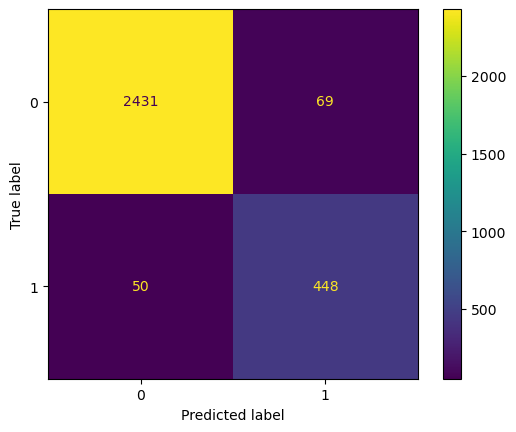

In [55]:
# Generate array of values for confusion matrix
preds = rf2.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=rf2.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=rf2.classes_)
disp.plot(values_format='');

The model predicts more false positives than false negatives, which means that some employees may be identified as at risk of quitting or getting fired, when that's actually not the case. But this is still a strong model.


#### Decision tree split

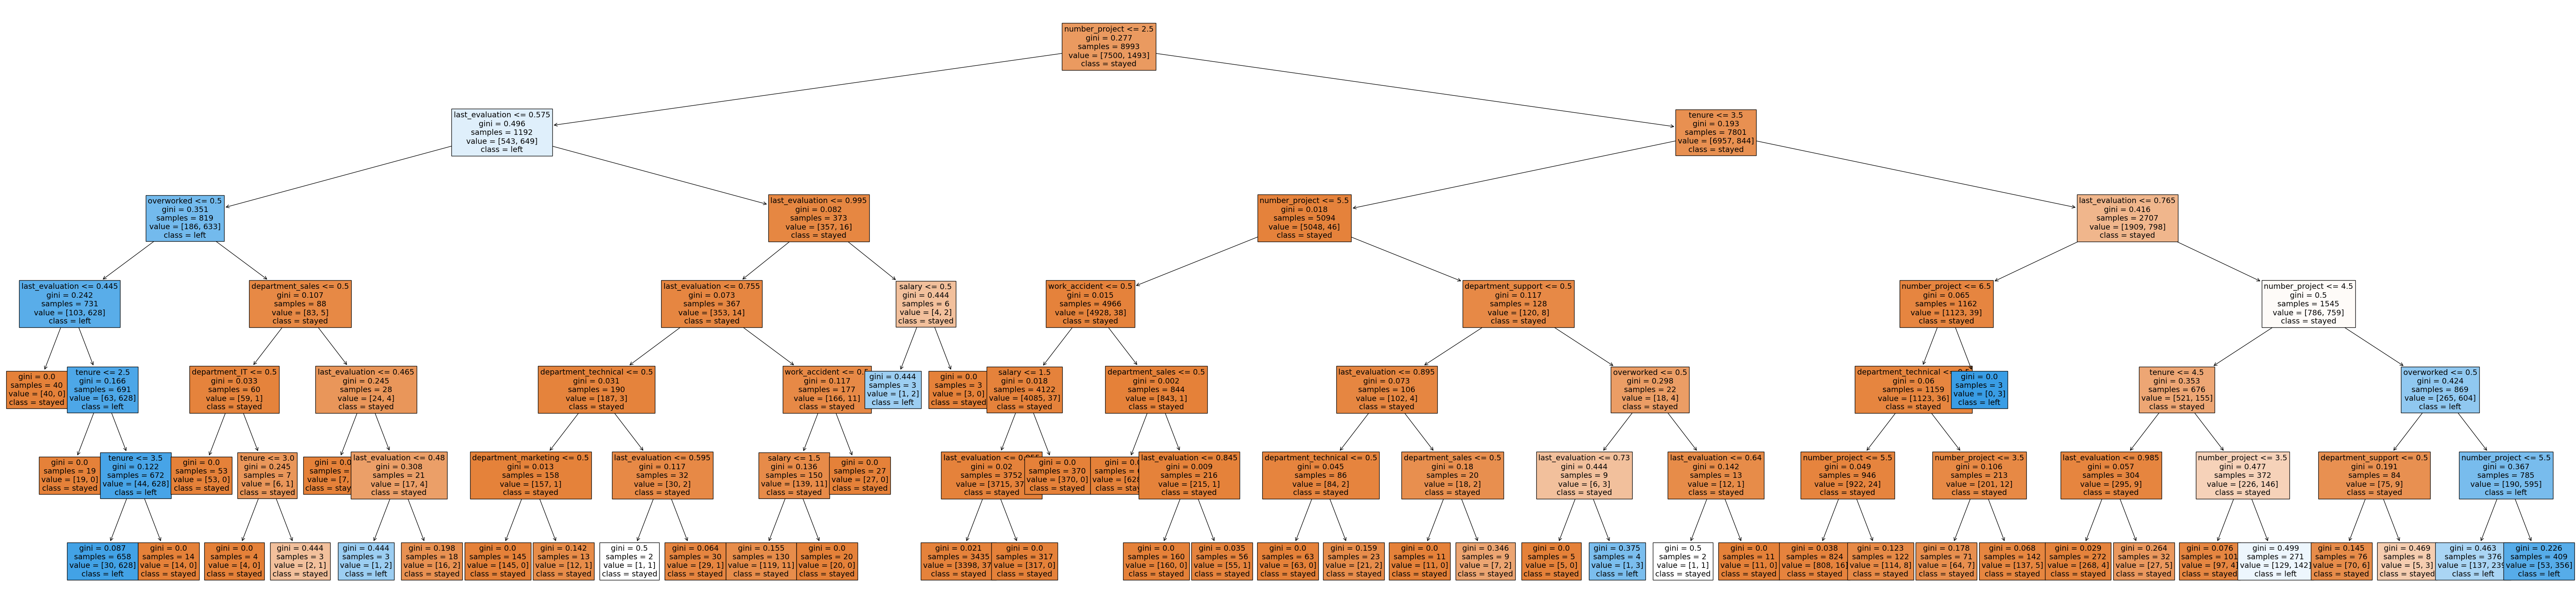

In [56]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree2.best_estimator_, max_depth=6, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

Note: Double click to zoom in on tree.

#### Decision tree feature importances

In [57]:
#tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns=X.columns)
tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, 
                                 columns=['gini_importance'], 
                                 index=X.columns
                                )
tree2_importances = tree2_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree2_importances = tree2_importances[tree2_importances['gini_importance'] != 0]
tree2_importances

,gini_importance
last_evaluation,0.344455
number_project,0.344147
tenure,0.216025
overworked,0.091911
department_support,0.001121
salary,0.000911
department_sales,0.000611
department_technical,0.000418
work_accident,0.000183
department_IT,0.000140


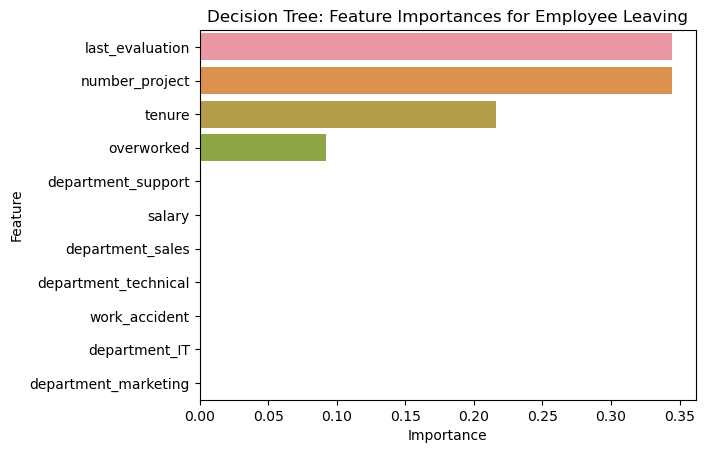

In [58]:
# plotting feature importance of tree
sns.barplot(data=tree2_importances, x="gini_importance", y=tree2_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

The plot above shows that in this random forest model, `last_evaluation`, `number_project`, `tenure`, and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`, and they are the same as the ones used by the decision tree model.

#### Random forest feature importance

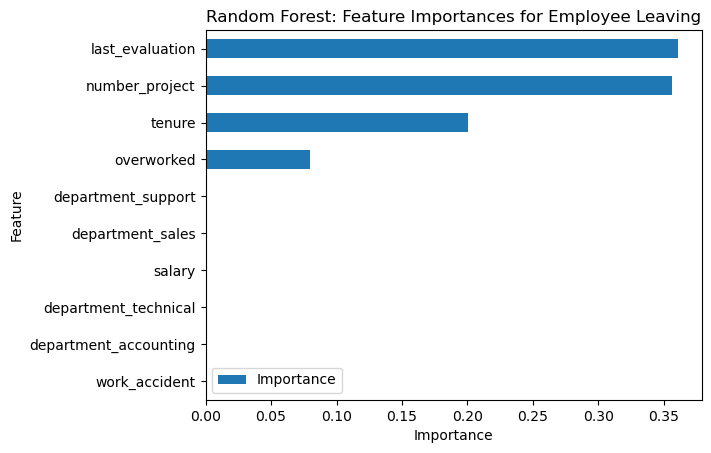

In [59]:
# Get feature importances
feat_impt = rf2.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf2.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features 
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()

The plot above shows that in this random forest model, `last_evaluation`, `number_project`, `tenure`, and `overworked` have the highest importance, in that order. These variables are most helpful in predicting the outcome variable, `left`, and they are the same as the ones used by the decision tree model.

## Step 4: Model Interpretation

### Evaluation metrics

- **AUC** is the area under the ROC curve; it's also considered the probability that the model ranks a random positive example more highly than a random negative example. 
- **Precision** measures the proportion of data points predicted as True that are actually True, in other words, the proportion of positive predictions that are true positives.
- **Recall** measures the proportion of data points that are predicted as True, out of all the data points that are actually True. In other words, it measures the proportion of positives that are correctly classified.
- **Accuracy** measures the proportion of data points that are correctly classified.
- **F1-score** is an aggregation of precision and recall.


### Summary of model results

**Logistic Regression**

The logistic regression model achieved precision of 79%, recall of 83%, f1-score of 80% (all weighted averages), and accuracy of 83%, on the test set.

**Tree-based Machine Learning**

After conducting feature engineering, the decision tree model achieved AUC of 93.6%, precision of 86.7%, recall of 90.0%, f1-score of 88.3%, and accuracy of 96.0%, on the test set. The random forest modestly outperformed the decision tree model. 

### Conclusion, Recommendations, Next Steps

The models and the feature importances extracted from the models confirm that employees at the company are overworked. 

To retain employees, the following recommendations could be presented to the stakeholders:

* Cap the number of projects that employees can work on.
* Consider promoting employees who have been with the company for atleast four years, or conduct further investigation about why four-year tenured employees are so dissatisfied. 
* Either reward employees for working longer hours, or don't require them to do so. 
* If employees aren't familiar with the company's overtime pay policies, inform them about this. If the expectations around workload and time off aren't explicit, make them clear. 
* Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts. 
* High evaluation scores should not be reserved for employees who work 200+ hours per month. Consider a proportionate scale for rewarding employees who contribute more/put in more effort. 

**Next Steps**

It may be justified to still have some concern about data leakage. It could be prudent to consider how predictions change when `last_evaluation` is removed from the data. It's possible that evaluations aren't performed very frequently, in which case it would be useful to be able to predict employee retention without this feature. It's also possible that the evaluation score determines whether an employee leaves or stays, in which case it could be useful to pivot and try to predict performance score. The same could be said for satisfaction score. 
